# Session 5: celib

## Overview

At CE, we have developed our own Python package, called `celib` (short for "CE library"). This package contains a number of submodules which, among other things:

- enable reading and writing in Python to file types associated with IDIOM models used at CE (E3ME, LEFM, etc)
- provide general-use helper functions to facilitate workflow in data processing and other tasks

In [29]:
import numpy as np
import pandas as pd
import celib

help(celib)

'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\celib\\__init__.py'

In this session we will focus on three submodules that are most relevant to economists' work:

- io/`DB1`
- io/`MRE`
- `fillmat`

The practical demonstrations will use examples from working with E3ME data, but the general principles are applicable across all models and teams at CE.

## DB1 files

DB1 file formats are used to store input data for IDIOM models. The `celib` submodule `DB1` is used to read and write to these files. 

In [2]:
from celib import DB1

### Opening databank files

We normally recommend opening DB1 files using the context manager (`with` statement), because it always ensures the file is closed cleanly.

In [3]:
with DB1('data/db1/U.db1') as dbu:
    ...    # Read data here

# After data is read in, DB1 file closes automatically

However, in this case we use the basic syntax to open the file, so we can read in data over multiple cells. We will need to remember to close this file later on.

In [4]:
dbu = DB1('data/db1/U.DB1')

### Indexing a databank
Each databank object has a property, `.index`, which allows us to inspect the structure of the databank. The index is returned as a pandas DataFrame, so we can manipulate it using the techniques presented in previous sessions.

In [5]:
dbu_index = dbu.index
dbu_index.head(3)

,name,comment,frequency,start_year,start_period,type_,nrows,ncols,user,date,caller,address,next_address
code,,,,,,,,,,,,,
17000070,OTI,HL E3ME_overall_classificat,0,0,0,4,11,0,UC,Thu Jun 14 10:52:08 2007,C:\Emissions 2021\01_update_dbu.py,193,361
4000070,GTI,HL E3ME_gov_spending,0,0,0,4,5,0,UC,Thu Jun 14 10:52:08 2007,C:\Emissions 2021\01_update_dbu.py,491,599
8000070,VTI,HL E3ME_assets_NACE_R17,0,0,0,4,7,0,UC,Thu Jun 14 10:52:08 2007,C:\Emissions 2021\01_update_dbu.py,732,946


### Reading data from a databank

#### One-dimensional data
The preview above shows that each variable is associated with both a name (e.g. 'GTI') and a code (e.g. 4000070).

In this case, `U.db1` contains metadata, specifically titles/indices for model data dimensions. GTI contains the titles for government spending categories. We can read in GTI using the same syntax as a dictionary, using either the variable name or the variable code as a label.

In [6]:
# Get variable by name
gti = dbu['GTI']
print(gti)

# Get variable by code
gti = dbu[4000070]
print(gti)

['1 Defence', '2 Education', '3 Health', '4 Other', '5 Unallocated']
['1 Defence', '2 Education', '3 Health', '4 Other', '5 Unallocated']


Note that while databank codes are always unique, databank names are not necessarily unique. While it is generally good practice to maintain unique variable names for each databank entry, duplicating variable names will not throw an error, and you may occasionally see examples of duplicated variable names on a given databank. 

Although getting variables by code is a more failsafe method as a result, getting variables by name is usually more user-friendly, and is the default method used by most economists at CE.

#### Two-dimensional data
DB1 files can store 1D data, which are read into Python as a simple list, as in the example above. But more commonly, each variable name is linked to a 2D matrix, which is read into Python as a 2D `numpy` array. 

For example, historical GDP data is stored in E3ME under the variable name 'RGDP' in `T.db1`.

In [7]:
dbt = DB1('data/db1/T.db1')
gdp = dbt['RGDP']

print('Type:', type(gdp))
print('Shape:', gdp.shape)
print('\n', gdp)

Type: <class 'numpy.ndarray'>
Shape: (71, 49)

 [[1.44704682e+05 1.50135442e+05 1.58026001e+05 ... 3.93201657e+05
  4.00924895e+05 4.06772005e+05]
 [1.13680566e+05 1.17096698e+05 1.21697839e+05 ... 2.67665327e+05
  2.73115504e+05 2.79646551e+05]
 [1.20652287e+06 1.24933430e+06 1.30155100e+06 ... 2.85762666e+06
  2.92806729e+06 2.97279184e+06]
 ...
 [5.10169588e+03 6.23294041e+03 7.29767805e+03 ... 4.17995331e+04
  4.38082918e+04 4.65762971e+04]
 [2.19350092e+04 2.65260577e+04 3.24774167e+04 ... 2.89654656e+05
  2.96443437e+05 3.00214982e+05]
 [1.00000000e-04 1.00000000e-04 1.00000000e-04 ... 1.00000000e-04
  1.00000000e-04 1.00000000e-04]]


We can include indexes with dimension titles to convert the `numpy` array above into a more readable `pandas` DataFrame. 

Finding the correct dimension titles to use is not always straightforward, since DB1 files do not include metadata on dimensions.

The column axis is almost always a 'year' dimension. The particular years covered by a variable can be inferred from the databank index, using information from the 'start_year' and 'ncols' columns. It is possible the 'start_year' field is empty, in which case you may need to consult the model IDIOM files or ask a colleague.

The row axis, meanwhile, is almost always a regional or sectoral dimension, although there can be many of these to choose from. If you do not know the particular dimensions of a given variable, you can look into the relevant model to find further information, or ask a colleague.

In this case, RGDP is a 2D 'regional' variable in E3ME (as is normally the case with variables beginning with 'R'), with the row axis representing the regional dimension.

In [8]:
regions = dbu['RTI']       # Region titles from U.db1
years = range(1970, 2019)  # Historical data starts in 1970, and there are 49 columns in this data

gdp = pd.DataFrame(dbt['RGDP'], index=regions, columns=years)
gdp.head(5)

,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
1 Belgium (BE),1.447047e+05,1.501354e+05,1.580260e+05,1.677008e+05,1.747437e+05,1.724249e+05,1.821716e+05,1.833123e+05,1.885218e+05,1.929353e+05,...,3.530284e+05,363140.1,3.692935e+05,3.720234e+05,3.737319e+05,3.796313e+05,3.873484e+05,3.932017e+05,4.009249e+05,4.067720e+05
2 Denmark (DK),1.136806e+05,1.170967e+05,1.216978e+05,1.266789e+05,1.252571e+05,1.234324e+05,1.307453e+05,1.331907e+05,1.361559e+05,1.414239e+05,...,2.386994e+05,243165.5,2.464160e+05,2.469741e+05,2.492792e+05,2.533161e+05,2.592502e+05,2.676653e+05,2.731155e+05,2.796466e+05
3 Germany (DE),1.206523e+06,1.249334e+06,1.301551e+06,1.367643e+06,1.379568e+06,1.359585e+06,1.431286e+06,1.472239e+06,1.516235e+06,1.582862e+06,...,2.461534e+06,2564400.0,2.665031e+06,2.676212e+06,2.687672e+06,2.747492e+06,2.795291e+06,2.857627e+06,2.928067e+06,2.972792e+06
4 Greece (EL),8.891090e+04,9.588401e+04,1.056251e+05,1.141716e+05,1.068202e+05,1.136231e+05,1.214071e+05,1.249802e+05,1.340345e+05,1.384355e+05,...,2.391337e+05,226031.5,2.053891e+05,1.903948e+05,1.842233e+05,1.855861e+05,1.847735e+05,1.844207e+05,1.871964e+05,1.908175e+05
5 Spain (ES),3.496212e+05,3.658760e+05,3.956915e+05,4.265111e+05,4.504748e+05,4.529165e+05,4.678799e+05,4.811631e+05,4.881999e+05,4.884057e+05,...,1.070963e+06,1072709.0,1.063973e+06,1.032485e+06,1.017665e+06,1.031749e+06,1.071318e+06,1.103793e+06,1.135712e+06,1.162413e+06


Alternatively, we can load variables directly as `pandas` DataFrames using `read_df()`.

The function doesn't assign row indices, but it adds column labels based on the start year.

In [9]:
gdp = dbt.read_df('RGDP')
gdp.index = regions
gdp.columns = years    # 'start_year' information missing on databank, so we have to manually add column dimension

gdp.head(5)

,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
1 Belgium (BE),1.447047e+05,1.501354e+05,1.580260e+05,1.677008e+05,1.747437e+05,1.724249e+05,1.821716e+05,1.833123e+05,1.885218e+05,1.929353e+05,...,3.530284e+05,363140.1,3.692935e+05,3.720234e+05,3.737319e+05,3.796313e+05,3.873484e+05,3.932017e+05,4.009249e+05,4.067720e+05
2 Denmark (DK),1.136806e+05,1.170967e+05,1.216978e+05,1.266789e+05,1.252571e+05,1.234324e+05,1.307453e+05,1.331907e+05,1.361559e+05,1.414239e+05,...,2.386994e+05,243165.5,2.464160e+05,2.469741e+05,2.492792e+05,2.533161e+05,2.592502e+05,2.676653e+05,2.731155e+05,2.796466e+05
3 Germany (DE),1.206523e+06,1.249334e+06,1.301551e+06,1.367643e+06,1.379568e+06,1.359585e+06,1.431286e+06,1.472239e+06,1.516235e+06,1.582862e+06,...,2.461534e+06,2564400.0,2.665031e+06,2.676212e+06,2.687672e+06,2.747492e+06,2.795291e+06,2.857627e+06,2.928067e+06,2.972792e+06
4 Greece (EL),8.891090e+04,9.588401e+04,1.056251e+05,1.141716e+05,1.068202e+05,1.136231e+05,1.214071e+05,1.249802e+05,1.340345e+05,1.384355e+05,...,2.391337e+05,226031.5,2.053891e+05,1.903948e+05,1.842233e+05,1.855861e+05,1.847735e+05,1.844207e+05,1.871964e+05,1.908175e+05
5 Spain (ES),3.496212e+05,3.658760e+05,3.956915e+05,4.265111e+05,4.504748e+05,4.529165e+05,4.678799e+05,4.811631e+05,4.881999e+05,4.884057e+05,...,1.070963e+06,1072709.0,1.063973e+06,1.032485e+06,1.017665e+06,1.031749e+06,1.071318e+06,1.103793e+06,1.135712e+06,1.162413e+06


#### Three-dimensional data

IDIOM models include 3D variables, usually disaggregated by region, sector and year. Employment by sector ('YRE' in E3ME) is a classic example of a 3D (or 'sectoral') variable in IDIOM models.

We (almost always) store 'sectoral' variables on databanks with a separate matrix for each region, using the region name as a suffix in the variable name (e.g. 'QR_DK' for Denmark). These matrices are therefore written in <em>sector x year</em> format.

We usually read 'sectoral' variables into Python as dictionaries of DataFrames.

In [10]:
regions_short = dbu['RSHORTTI']
industries = dbu['YTI']

yre = {}
for region in regions_short:
    yre[region] = pd.DataFrame(dbt['YRE_{}'.format(region)], index=industries, columns=range(1970,2019))

yre['DK'].head()

,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
1 Crop production,238.297554,227.073309,218.157351,213.157994,207.739117,202.000000,201.000000,196.000000,189.000000,184.000000,...,64.000000,63.000000,62.000000,61.00000,61.00000,62.000000,64.000000,63.000000,63.000000,63.000000
2 Forestry,5.197909,5.155865,5.115109,5.076745,5.038365,5.000000,5.000000,5.000000,5.000000,4.000000,...,5.000000,6.000000,6.000000,6.00000,6.00000,6.000000,6.000000,6.000000,6.000000,6.000000
3 Fishing,12.199898,11.715117,11.254374,10.821031,10.403007,10.000000,10.000000,9.000000,8.000000,7.000000,...,3.000000,3.000000,3.000000,3.00000,2.00000,2.000000,2.000000,2.000000,2.000000,2.000000
4 Coal,2.912748,2.804468,2.700213,2.599834,2.503186,2.410131,2.380303,2.349373,3.089789,3.045619,...,1.666667,1.598738,1.532305,1.76093,1.12337,1.074138,1.026293,0.979866,0.934879,1.114184
5 Oil and Gas,0.523424,0.536085,0.549053,0.562335,0.575937,0.589869,0.619697,0.650627,0.910211,0.954381,...,3.333333,3.401262,3.467695,4.23907,2.87663,2.925862,2.973707,3.020134,3.065121,3.885816


### Creating a databank
`DB1.create()` can be used to create a databank. A valid username must be set before using this method. 

In [11]:
with DB1() as db1:
    db1.user = 'CE'
    db1.create('out/temp.db1')

### Writing to a databank
Data can be written to the databank in 1D format (passing a list object into `write_list`) or in 2D format (passing a `numpy` array into `write_matrix`).

In order to write data to the databank, you must, at a minimum:
- set mode='write' when opening the DB1 file (as opposed to the default 'read')
- define a username under `DB1.user`
- pass in a variable name and code, along with the data, as arguments into the `write_list` or `write_matrix` method

It is also good practice to include a short and informative comment describing the data you have written.

In [12]:
with DB1('out/temp.db1', 'write') as db1:             # Set mode='write'
    db1.user = 'CE'                                   # Set username
    
    db1.write_list('Labels_1',                        # Name
                   200,                               # Code
                   list('XYZ'),                       # Data
                  'Test list')                        # Comment (recommended)
    
    db1.start_year = 1970
    db1.write_matrix('Matrix_1',                      # Name
                     100,                             # Code
                     np.arange(12).reshape((3, -1)),  # Data
                     'Test matrix')                   # Comment (recommended)
    
    # Inspect the index of the new databank
    display(db1.index)

,name,comment,frequency,start_year,start_period,type_,nrows,ncols,user,date,caller,address,next_address
code,,,,,,,,,,,,,
200,Labels_1,Test list,0,0,0,4,3,0,CE,Tue Jul 20 12:46:39 2021,C:\ProgramData\Anaconda3\lib\runpy.py,170,209
100,Matrix_1,Test matrix,0,0,0,3,3,4,CE,Tue Jul 20 12:46:39 2021,C:\ProgramData\Anaconda3\lib\runpy.py,325,421


### Scratching data
When overwriting a variable/databank entry (as identified by a unique variable code), the pre-existing variable must first be deleted ('scratched') before the new data is written, since each variable must have a unique databank code.

This can be achieved with `scratch`, although this will return an error if the specified code doesn't exist on the databank. A more failsafe method is to use `scratch_if_exists`.

It is usually good practice to use `scratch_if_exists` even if you are not overwriting data. Otherwise, if you run your script twice, you will run into an error saying the variable already exists.

Whatever reason it is you are scratching your data, **make sure to scratch the right variable code**. It can be easy to get this wrong and delete the wrong data by accident.

In [13]:
with DB1('out/temp.db1', 'write') as db1:
    db1.user = 'CE'
    
    db1.scratch_if_exists(100)
    db1.write_matrix('Matrix_1_v2',                   # Name
                     100,                             # Code
                     np.arange(12).reshape((3, -1)),  # Data
                     'Test matrix')                   # Comment
    
    # Inspect the index of the new databank
    display(db1.index)

,name,comment,frequency,start_year,start_period,type_,nrows,ncols,user,date,caller,address,next_address
code,,,,,,,,,,,,,
200,Labels_1,Test list,0,0,0,4,3,0,CE,Tue Jul 20 12:46:39 2021,C:\ProgramData\Anaconda3\lib\runpy.py,170,209
100,Matrix_1_v2,Test matrix,0,0,0,3,3,4,CE,Tue Jul 20 12:46:40 2021,C:\ProgramData\Anaconda3\lib\runpy.py,540,636


### Condensing databanks
'Scratching' variables from a databank does not actually delete them from the file. Instead it simply switches the variable code to a negative value, which effectively marks the data as 'scratched' and prevents it from being read.

This means that repeatedly writing and scratching the same variable will increase the total size of the DB1 file. If you are scratching large quantities of data, it is good practice to `condense` the databank. This operation will remove all scratched variables from the DB1 file. It can be an expensive operation, however, as it involves writing a whole new databank from the ground up, copying the non-scratched variables from your databank one-by-one.

As a result, it is best practice to condense the databank once, after all other operations have been completed.

In [14]:
with DB1('out/temp.db1', 'write') as db1:
    db1.user = 'CE'
    
    db1.scratch_if_exists(100)
    db1.write_matrix('Matrix_1_v3',                   # Name
                     100,                             # Code
                     np.arange(12).reshape((3, -1)),  # Data
                     'Test matrix')                   # Comment
    
    db1.condense()

----------------------

## MRE files

MRE ('Model REsult') files generally contain outputs from running our in-house IDIOM models. The `MRE` submodule provides functionality for reading from and writing to MRE files.

In [15]:
from celib import MRE

### Opening and indexing MRE files

MRE files are structured as simple text files. Each set of variable data is prefixed by a line of metadata, indicating the variable name, type and dimensions.

In [16]:
with open('data/mre/E3ME_scenario_results_small.mre') as file:
    print(file.read(100000))

43  51  CR  ? 01 consumers' expenditures
     20904.9004     20611.2246     21116.2617     21086.9648     21639.4375     22207.7207     22559.4102     22859.8301     23090.8398     23608.8066     26379.0957     31609.1816     32240.5312     33707.5156     34857.8164     35655.7930     36301.8164     37097.9453     37919.4805     38769.5312     39638.5273     40052.7227     40471.1094     40900.8789     41345.0195     41808.4414     42190.3555     42607.2383     43035.4414     43459.9297     43876.6719     44718.2461     45581.4219     46449.8242     47323.3984     48212.4492     49184.7656     50194.9844     51223.5742     52281.8086     53371.5508     54021.1367     54670.9922     55334.4844     55983.6250     56616.4570     57283.1914     57936.0898     58569.5000     59216.5742     59847.5156
      4950.6001      5000.9204      4968.3604      4944.4604      4987.2168      4975.8149      4777.3833      4777.2734      4795.1436      4887.6660      5592.1787      5189.4668      5276.54

MRE files can be large: E3ME results files can reach over 500MB in size.

Consequently, the MRE class doesn't load whole MRE files into the memory. It loads an *index* of a file, from a scan of the metadata in the file. The user then queries this index; whenever a variable is referenced, the source file is opened and the corresponding data loaded.

You can inspect the MRE index in the same way as with DB1 files - although with MREs, the `.index` property returns a dictionary rather than a DataFrame.

In [17]:
with MRE('data/mre/E3ME_scenario_results_small.mre') as mre:
    mre_index = mre.index   # Returns a dictionary

# Display index dictionary 
## Filter RGDP and YRE only (2D and 3D variable examples)
{var: mre_index[var] for var in ['RGDP', 'YRE']}

{'RGDP': {0: {'position': 29499714,
   'lines': 71,
   'rows': 71,
   'cols': 51,
   'nperl': 1,
   'comment': 'GDP expenditure measure at market prices (RSC+RSG+RSK+RSS+RS'}},
 'YRE': {0: {'position': 30044787,
   'lines': 70,
   'rows': 70,
   'cols': 51,
   'nperl': 1,
   'comment': '? 01 industry employment (employees+self-employed)'},
  1: {'position': 30098542,
   'lines': 70,
   'rows': 70,
   'cols': 51,
   'nperl': 1,
   'comment': '? 02 industry employment (employees+self-employed)'},
  2: {'position': 30152297,
   'lines': 70,
   'rows': 70,
   'cols': 51,
   'nperl': 1,
   'comment': '? 03 industry employment (employees+self-employed)'},
  3: {'position': 30206052,
   'lines': 70,
   'rows': 70,
   'cols': 51,
   'nperl': 1,
   'comment': '? 04 industry employment (employees+self-employed)'},
  4: {'position': 30259807,
   'lines': 70,
   'rows': 70,
   'cols': 51,
   'nperl': 1,
   'comment': '? 05 industry employment (employees+self-employed)'},
  5: {'position': 30313562

### Reading data from an MRE file
MRE variables do not contain codes (as databank variables do). There is no need, since IDIOM models produce a separate MRE file for each scenario run. Hence, variables can only contain up to 3 dimensions, and we do not face the issue of duplicate variable names: each variable name is a unique identifier of model output data for a given scenario file.

Accordingly, data can be retrieved from MRE files using variable names as keys, as with databanks. This method always returns a list of NumPy arrays.

In [18]:
# Normally use context manager, but here we are reading in data across 
# multiple cells, so we use the basic syntax
mre = MRE('data/mre/E3ME_scenario_results_small.mre')

rgdp_list = mre['RGDP']  # 2D variable
yre_list = mre['YRE']    # 3D variable

print('Variable: RGDP')
print('Type: {}'.format(type(rgdp_list)))
print('Length: {}'.format(len(rgdp_list)))
print('Shape of arrays: {}'.format(rgdp_list[0].shape))

print('\nVariable: YRE')
print('Type: {}'.format(type(yre_list)))
print('Length: {}'.format(len(yre_list)))
print('Shape of arrays: {}'.format(yre_list[0].shape))

Variable: RGDP
Type: <class 'list'>
Length: 1
Shape of arrays: (71, 51)

Variable: YRE
Type: <class 'list'>
Length: 71
Shape of arrays: (70, 51)


For regional (2D) variables such as RGDP, the array can be retrieved by returning the first (only) item in this list. We can store this as a pandas DataFrame.

For sectoral (3D) variables such as YRE, each array in the list is associated with a different region. The standard approach is to read 3D variables into Python as a dictionary of DataFrames.

Note: as with databanks, there is no metadata in the MRE file for the dimension titles. To know what labels to use, you must look at the original IDIOM instructions that produce the MRE output.

In [19]:
years = range(2010, 2061)  

rgdp = pd.DataFrame(mre['RGDP'][0], index=regions_short, columns=years)

yre = {}
for r, reg in enumerate(regions_short):
    yre[reg] = pd.DataFrame(mre['YRE'][r], index=industries, columns=years)

yre['DK'].head()

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,...,2051,2052,2053,2054,2055,2056,2057,2058,2059,2060
1 Crop production,63.0000,62.0000,61.0000,61.0000,62.0000,64.0000,63.0000,63.0000,63.0000,63.2761,...,51.2123,51.6157,51.9759,52.2859,52.5436,52.7279,52.8549,52.9448,52.9962,53.0353
2 Forestry,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0267,...,5.9245,6.0255,6.1274,6.2317,6.3365,6.4380,6.5395,6.6443,6.7496,6.8569
3 Fishing,3.0000,3.0000,3.0000,2.0000,2.0000,2.0000,2.0000,2.0000,2.0000,2.0089,...,2.0306,2.0727,2.1179,2.1658,2.2147,2.2595,2.3002,2.3357,2.3673,2.3972
4 Coal,1.5987,1.5323,1.7609,1.1234,1.0741,1.0263,0.9799,0.9349,1.1142,0.7788,...,1.0845,1.0879,1.0915,1.0952,1.0990,1.1034,1.1079,1.1127,1.1176,1.1227
5 Oil and Gas,3.4013,3.4677,4.2391,2.8766,2.9259,2.9737,3.0201,3.0651,3.8858,3.8534,...,5.2586,5.2316,5.2035,5.1759,5.1492,5.1737,5.1992,5.2383,5.2549,5.2939


### Writing data to an MRE file

Data can be written to MREs using the `write` method, although the use cases for this are few, since MRE files are usually only used to store IDIOM model output.

Data to write must be formatted as a dictionary of numpy arrays, where the keys correspond to the assigned variable names. 3D variables must be formatted as dictionaries, with lists of NumPy arrays as values and variable names as keys. 

The same is true of comments, which must be formatted as dictionaries of (lists of) strings, with keys corresponding to variable names.

In [20]:
# Writing 2D variables
fp = 'out\REMP.mre'
rgdp = np.arange(71*51).reshape(71,51)
remp = np.arange(71*51).reshape(71,51)

# Data and comment should be stored as dictionaries with keys 
data_dict = {'REMP': remp,
             'RGDP': rgdp}
comments_dict = {'REMP': 'Employment by region',
                 'RGDP': 'GDP by region'}

# Write to MRE
mre_new = MRE()
mre_new.write(data_dict, comments_dict, fp)

# Check index of new MRE
with MRE(fp) as mre:
    print(dict(mre.index))

{'REMP': {0: {'position': 36, 'lines': 71, 'rows': 71, 'cols': 51, 'nperl': 1, 'comment': 'Employment by region'}}, 'RGDP': {0: {'position': 54522, 'lines': 71, 'rows': 71, 'cols': 51, 'nperl': 1, 'comment': 'GDP by region'}}}


---

## fillmat
`fillmat` (short for 'fill matrix') is a `celib` module containing helper functions to streamline data processing tasks. Specifically, it defines a collection of algorithms to fill in missing data in pandas DataFrames.

These functions are extremely useful when producing and updating historical data in CE's IDIOM models, as source data is often limited relative to the model requirements: regions and sectors can be aggregated at a coarse level, or data may be missing for certain years.

In this section, we take a closer look at a handful of key `fillmat` functions which you may find useful. For more information on other `fillmat` modules, call `help(fillmat)` to read the documentation.

In [21]:
from celib import fillmat as fm
from numpy import nan

help(fm)

Help on module celib.fillmat in celib:

NAME
    celib.fillmat

DESCRIPTION
    fillmat
    
    Functions to fill a DataFrame/Series/Numpy array that contains missing data.
    
    Filling functions are:
        - fill_with_shares - fill where all years are missing by sharing out
                             a total based on supplied shares
        - fill_with_growth_rates - fill gaps at the two ends of a series
                                   using growth rates from another variable
        - extrapolate - fill gaps at the two ends of a series by extrapolation
        - interpolate - fill gaps in the middle of a series by interpolation
                        for up to 6 blocks of missing data
        - restricted_fill_forward - fill gaps at the end of a series by extrapolating
                                    forward subject to a constraint (target growth
                                    rates eg previous version of the variable)
        - restricted_fill_backward - fill g

### extrapolate
The `extrapolate` function fills in any gaps at the beginning or end of a time-series. Any gaps in the middle of the series will be left as NaNs.

This algorithm extrapolates uses a constant growth rate assumption from the between existing data points. Note that this means that filled values will always have a convex shape.

      fillmat (growth)  original
2000         44.444444       NaN
2001         49.185863       NaN
2002         54.433105       NaN
2003         60.240134       NaN
2004         66.666667       NaN
2005         73.778795       NaN
2006         81.649658       NaN
2007         90.360200       NaN
2008        100.000000     100.0
2009        120.000000     120.0
2010               NaN       NaN
2011        130.000000     130.0
2012        150.000000     150.0
2013        166.002288       NaN
2014        183.711731       NaN
2015        203.310451       NaN
2016        225.000000       NaN
2017        249.003432       NaN
2018        275.567596       NaN
2019        304.965676       NaN
2020        337.500000       NaN


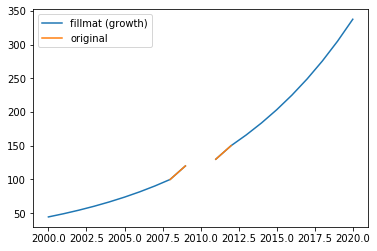

In [22]:
series = pd.Series([nan, nan, nan, nan, nan, nan, nan, nan, 100, 120, nan, 130, 150, nan, nan, nan, nan, nan, nan, nan, nan], 
                   index=range(2000, 2021))

df = pd.DataFrame(index=range(2000, 2021))

df['fillmat (growth)'] = fm.extrapolate(series)
df['original'] = series

print(df)
df.plot.line()

### interpolate
The `interpolate` function fills in any gaps in the middle of a time-series. Any gaps at either end of the series will be left as NaNs.

As with the `extrapolate` function, note that this fillmat algorithm assumes constant growth rates between existing data points, which means that the filled data are always convex in shape. 

This can be compared to `pandas`' native `interpolate` method for Series and DataFrames, which offers the choice of different interpolation methods, such as 'linear' or 'cubic'. See the graph below for a comparison.

      fillmat (growth)  pandas (linear)  pandas (cubic)
2001               NaN              NaN             NaN
2002               NaN              NaN             NaN
2003         10.000000             10.0       10.000000
2004         13.195079             16.0       25.948718
2005         17.411011             22.0       35.766026
2006         22.973967             28.0       40.608974
2007         30.314331             34.0       41.634615
2008         40.000000             40.0       40.000000
2009         37.224194             37.5       36.862179
2010         34.641016             35.0       33.378205
2011         32.237098             32.5       30.705128
2012         30.000000             30.0       30.000000
2013         37.077928             40.0       32.419872
2014         45.825757             50.0       39.121795
2015         56.637470             60.0       51.262821
2016         70.000000             70.0       70.000000
2017               NaN             70.0         

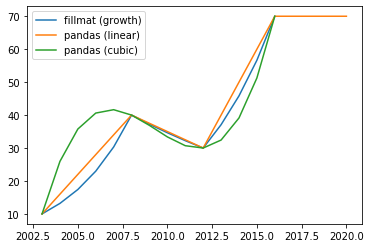

In [23]:
series = pd.Series([nan, nan, nan, 10, nan, nan, nan, nan, 40, nan, nan, nan, 30, nan, nan, nan, 70, nan, nan, nan, nan], 
                   index=range(2000,2021))

df = pd.DataFrame(index=range(2001,2021))

df['fillmat (growth)'] = fm.interpolate(series)
df['pandas (linear)'] = series.interpolate()
df['pandas (cubic)'] = series.interpolate('cubic')

print(df)
df.plot.line()

### fill_with_growth_rates
Fills missing data in one series using growth rates from another series.

We may, for instance, want to build a very basic forecast of employment, with the assumption that it will grow with population. It would be simple to calculate this forecast manually, but even easier to just use the `fillmat` function.

      population  employment_filled  employment
2000        1000         800.000000       800.0
2001        1100         700.000000       700.0
2002        1150         900.000000       900.0
2003        1100         860.869565         NaN
2004        1200         939.130435         NaN
2005        1300        1017.391304         NaN
2006        1400        1095.652174         NaN
2007        1450        1134.782609         NaN
2008        1200         939.130435         NaN
2009        1400        1095.652174         NaN
2010        1500        1173.913043         NaN


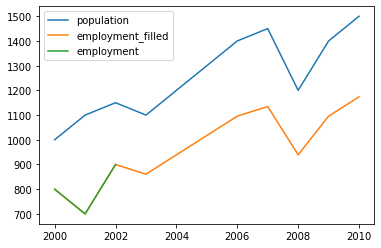

In [24]:
df = pd.DataFrame(index=range(2000,2011))

pop = pd.Series([1000, 1100, 1150, 1100, 1200, 1300, 1400, 1450, 1200, 1400, 1500], index=range(2000,2011))
emp = pd.Series([800, 700, 900, nan, nan, nan, nan, nan, nan, nan, nan], index=range(2000,2011))

df['population'] = pop
df['employment_filled'] = fm.fill_with_growth_rates(emp, pop)
df['employment'] = emp

print(df)
df.plot.line()

## Postscript: closing files
Since we didn't use a context manager to open our DB1 and MRE files earlier in the notebook, we now need to make sure to close them. 

Did you remember? I almost didn't, and that's exactly why context managers are generally a good idea.

In [25]:
dbu.close()
dbt.close()
mre.close()
mre_new.close()